## Cattle Detection using Bag-of-Visual-Words

### Bibliotecas utilizadas nesta implementacao

In [1]:
import cv2  # Biblioteca OpenCV para gerar descritores das imagens
import glob # Biblioteca para trabalhar com diretorios
import time # Biblioteca calcular tempo de treinamento
import numpy as np # Biblioteca de manipulacao de vetores

import matplotlib.image as mpimg # Bibliotecas para plotagem e exibicao de imagens
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC  # Biblioteca para utilizar Classificador
from sklearn.cluster import KMeans # Biblioteca para utilizar K-means
#from scipy.ndimage.measurements import label 


from sklearn.model_selection import train_test_split  # Biblioteca para dividir dataset em trainamento e teste

In [2]:
# Variaveis globais

svc = None # variavel para o classificador
detector= None # Variavel para o detector SIFT
kmeans= None # Variavel para o k-means
num_k= 250 # Numero de K

## Funcao para treinamento do classificador

##### Essa função recebe dois conjuntos de imagens, sendo da classe positiva e negativa, e calcula os KeyPoints de cada uma delas com uso do SIFT.

##### Com os Keypoints criados, o algoritmo k-means é aplicado para agrupar esses KeyPoints

##### Depois disso, para cada imagem, os descritores são atribuídos ao cluster mais próximo, onde cada imagem é agora representada pelo histograma de frequência dos grupos em que seus respectivos key-points fazem parte.

##### Esses histogramas são usados para treinar um classificador SVM

In [3]:
def training():
    global detector
    global svc
    global kmeans
    detector=cv2.xfeatures2d.SIFT_create()
    
    # Read in cars and notcars
    cattle = glob.glob('train_images/Cattle/*.jpg')
    non_cattle = glob.glob('train_images/Not-Cattle/*.jpg')

    sample_size = 250
    cattle = cattle[0:sample_size]
    non_cattle = non_cattle[0:sample_size]

    print("Loading", len(cattle), "cattle images...")
    print("Loading", len(non_cattle), "non-cattle images...")


    catt_features = np.empty((0,128))
    notcatt_features = np.empty((0,128))
    for image in non_cattle:
        notcatt=cv2.imread(image,3)
        trainKP,trainDesc = detector.detectAndCompute(notcatt,None)
        if trainDesc is not None:
            notcatt_features = np.vstack((notcatt_features, trainDesc))
    for image in cattle:
        catt=cv2.imread(image,0)
        trainKP,trainDesc = detector.detectAndCompute(catt,None)
        if trainDesc is not None:
            catt_features = np.vstack((catt_features, trainDesc))


    X = np.vstack((catt_features, notcatt_features)).astype(np.float64)
    
    # Aplied the k-means algorithm to generate k centroids of 128 features
    kmeans = KMeans(n_clusters=num_k, random_state=0).fit(X)
    
    
    catt_k_train = np.empty((0,num_k))
    notcatt_k_train = np.empty((0,num_k))
    for image in non_cattle:
        notcatt=cv2.imread(image,3)
        trainKP,trainDesc = detector.detectAndCompute(notcatt,None)
        h_img = np.zeros(num_k)
        if trainDesc is not None:
            classes = kmeans.predict(trainDesc)
            for i in range(num_k):
                h_img[i] = len(np.where(classes == i)[0])
            h_img = h_img / np.linalg.norm(h_img) # Normalize the vector using L1
            notcatt_k_train = np.vstack((notcatt_k_train, h_img))
    for image in cattle:
        catt=cv2.imread(image,0)
        trainKP,trainDesc = detector.detectAndCompute(catt,None)
        h_img = np.zeros(num_k)
        if trainDesc is not None:
            classes = kmeans.predict(trainDesc)
            for i in range(num_k):
                h_img[i] = len(np.where(classes == i)[0])
            h_img = h_img / np.linalg.norm(h_img) # Normalize the vector using L1
            catt_k_train = np.vstack((catt_k_train, h_img))
    
    
    X = np.vstack((catt_k_train, notcatt_k_train)).astype(np.float64)
    

    # Define the labels vector
    y = np.hstack((np.ones(len(catt_k_train)), np.zeros(len(notcatt_k_train))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)


    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    # Check the prediction time for a single sample
    t=time.time()

In [4]:
# Chama a funcao de treinamento do classificador
training()

Loading 250 cattle images...
Loading 250 non-cattle images...


KeyboardInterrupt: 

### Função para classificar uma imagem como Cattle ou not-Cattle

In [8]:

def predizer(img):
    trainKP,trainDesc = detector.detectAndCompute(img,None)
    h_img = np.zeros((1, num_k))
    if trainDesc is not None:
        classes = kmeans.predict(trainDesc)
        for i in range(num_k):
            h_img[0,i] = len(np.where(classes == i)[0])
    test_prediction = svc.predict(h_img)
    return test_prediction # 0- Cattle , 1- not-Cattle


### Janela deslizante de tamanho fixo para encontrar objetos em uma imagem inteira

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cattle(img, pix_per_cell):

    draw_img = np.copy(img)
    # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell)-1
    nyblocks = (img.shape[0] // pix_per_cell)-1 
    #nfeat_per_block = orient*cell_per_block**2
    
    bboxes = []
    for xb in range(nxblocks):
        for yb in range(nyblocks):

            xleft = xb*pix_per_cell
            ytop = yb*pix_per_cell
   
            trainKP,trainDesc = detector.detectAndCompute(img[ytop:ytop+pix_per_cell-1, xleft:xleft+pix_per_cell-1],None)
            h_img = np.zeros((1, num_k))
            if trainDesc is not None:
                classes = kmeans.predict(trainDesc)
                for i in range(num_k):
                    h_img[0,i] = len(np.where(classes == i)[0])
            test_prediction = svc.predict(h_img)
            
            if test_prediction == 0:
                xbox_left = np.int(xleft)
                ytop_draw = np.int(ytop)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw),(xbox_left+pix_per_cell,ytop_draw+pix_per_cell),(0,0,255),4) 
                #bboxes.append(((xbox_left, ytop_draw),(xbox_left+pix_per_cell,ytop_draw+pix_per_cell)))
    return draw_img

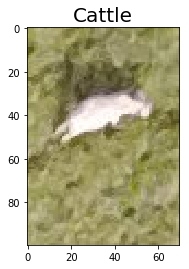

In [31]:
if __name__ == "__main__":
    img = cv2.imread("Cattle/yes (1111).jpg",3)
    img = img[...,::-1]
    if predizer(img) == 0:
        title = "Cattle"
    else:
        title = "Not-Cattle"

    fig = plt.figure()
    fig.set_size_inches(6, 4)
    plt.imshow(img.astype(np.uint8))
    plt.title(title, fontsize=20)

In [20]:
img =cv2.imread("test_images/DJI_0469.JPG",1)
img = img[...,::-1]
img = img[0::3,0::4,::]

In [29]:
draw_image = find_cattle(img, 25)

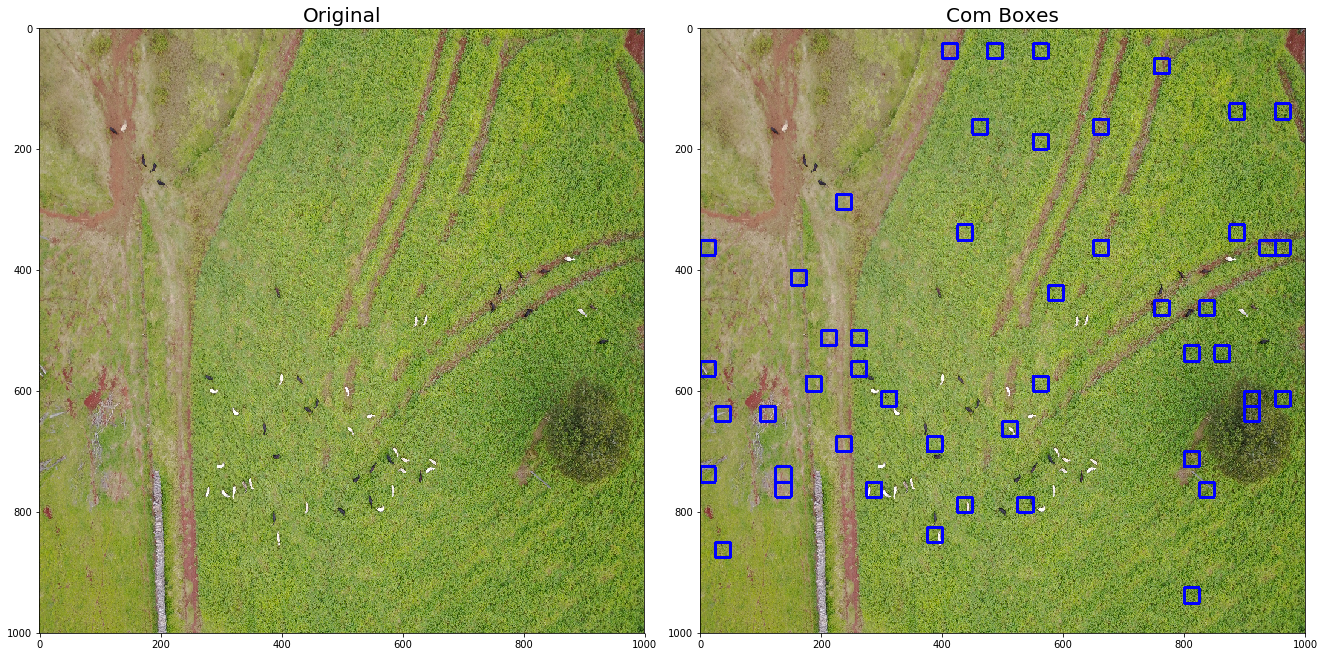

In [30]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(121)
plt.imshow(img.astype(np.uint8))
plt.title('Original', fontsize=20)
plt.subplot(122)

plt.imshow(draw_image)
plt.title('Com Boxes', fontsize=20)
fig.tight_layout()=
